Имортирую нужные для работы библиотеки

In [388]:
import pandas as pd
import seaborn as sns
import re
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

Считываю ссылку, предоставленную для задания №1 и задания №2

In [390]:
url = "https://docs.google.com/spreadsheets/d/1jSzvqVkgZhRzAZ07H5aLerPa4TMop0vNMwjug2uw9DA/export?format=csv&gid=812556653"

In [391]:
# считываю данные, заменяю пробелы в названиях столбцов
data = pd.read_csv(url, delimiter=",", on_bad_lines='skip')
data.columns = data.columns.str.replace('\xa0', ' ')

In [392]:
data.head()

,id лида,Язык лида,Год заявки,Квартал заявки,Страна покупки или заявки,"Цена сделки или бюджет, €",Год сделки,Квартал сделки,Страна покупки
0,52216,ru,2017,3,Грузия,NaN,NaN,NaN,NaN
1,52529,ru,2017,3,Португалия,400000.0,NaN,NaN,NaN
2,50573,ru,2017,2,США,125122.0,NaN,NaN,NaN
3,40445,ru,2017,1,Латвия,300000.0,NaN,NaN,NaN
4,64589,ru,2017,4,Испания,130000.0,NaN,NaN,NaN


## Задание 1

Посчитайте кумулятивную конверсию из лидов в сделку для Таиланда.
Периоды создания/закрытия – кварталы годов.


Отфильтрую строки, где в столбце "Страна покупки или заявки" указана "Таиланд", буду использовать регулярные варыжения, так как в столбце со страной есть значения, содержащие 2 страны.

In [393]:
thailand_data = data[data['Страна покупки или заявки'].str.contains(r'.*Таиланд.*', na=False, regex=True)]

In [394]:
thailand_data.head(5)

,id лида,Язык лида,Год заявки,Квартал заявки,Страна покупки или заявки,"Цена сделки или бюджет, €",Год сделки,Квартал сделки,Страна покупки
17,55144,ru,2017,3,Таиланд,227000.0,NaN,NaN,NaN
41,46343,ru,2017,2,Таиланд,170295.0,NaN,NaN,NaN
64,49893,ru,2017,2,Таиланд,100000.0,NaN,NaN,NaN
73,67171,ru,2017,4,Таиланд,362799.0,NaN,NaN,NaN
81,43587,ru,2017,1,Таиланд,NaN,NaN,NaN,NaN


Сгруппирую данные по году и кварталу подачи заявки и сделки

In [395]:
grouped_data = thailand_data.groupby(['Год заявки', 'Квартал заявки']).agg(
    leads=('id лида', 'count'), 
    deals=('Год сделки', lambda x: x.notna().sum()) 
).reset_index()

Вычисляю кумулятивную конверсию как отношение количества сделок к количеству лидов

In [396]:
# создаю столбцы с кумулятивными данными
grouped_data['cumulative_leads'] = grouped_data['leads'].cumsum()
grouped_data['cumulative_deals'] = grouped_data['deals'].cumsum()

# расчитываю кумулятивную конверсию
grouped_data['cumulative_conversion'] = (
    grouped_data['cumulative_deals'] / grouped_data['cumulative_leads']
)


Выведу результаты

In [397]:
grouped_data

,Год заявки,Квартал заявки,leads,deals,cumulative_leads,cumulative_deals,cumulative_conversion
0,2017,1,20,0,20,0,0.000000
1,2017,2,10,0,30,0,0.000000
2,2017,3,11,0,41,0,0.000000
3,2017,4,18,0,59,0,0.000000
4,2018,1,26,0,85,0,0.000000
5,2018,2,30,1,115,1,0.008696
6,2018,3,32,3,147,4,0.027211
7,2018,4,124,6,271,10,0.036900
8,2019,1,115,2,386,12,0.031088
9,2019,2,119,6,505,18,0.035644


## Задание 2

Как изменился спрос на ТОП-5 стран на покупку недвижимости у
русскоязычных клиентов в 1 кв. 2019 относительно 1 кв. 2018. Напишите краткое
сравнение по ТОП-5 странам. Как изменились медианные/средние бюджеты
клиентов по странам. Выбор в пользу какого параметра (медианные/средние)
Вы сделали? Почему? 

Фильтрую данные для 1 квартала 2018 и 2019 годов (рускоязычные)

In [398]:
q1_data = data[(data['Квартал заявки'] == 1) & 
                     (data['Год заявки'].isin([2018, 2019])) & 
                     (data['Язык лида'] == 'ru')]


Разделю столбец 'Страна покупки или заявки' на самостоятельные строки.

In [400]:
# разделяю строки на списки стран
q1_data['Страна покупки или заявки'] = q1_data['Страна покупки или заявки'].astype(str).str.split(',')

# разделяю списки на отдельные строки
q1_data = q1_data.explode('Страна покупки или заявки')

# убираю лишние пробелы, если есть
q1_data['Страна покупки или заявки'] = q1_data['Страна покупки или заявки'].str.strip()


Определяю ТОП-5 стран по числу покупок недвижимости

In [401]:
top_countries = (
    q1_data.groupby('Страна покупки или заявки')
    .agg(purchases=('Страна покупки', 'count'))
    .sort_values(by='purchases', ascending=False)
    .head(5)
    .index
)

Фильтрую данные для ТОП-5 стран

In [402]:
top_countries_data = q1_data[q1_data['Страна покупки или заявки'].isin(top_countries)]


Сравниваю спрос и бюджеты по годам

In [403]:
demand_budget_comparison = top_countries_data.groupby(['Год заявки', 'Страна покупки или заявки']).agg(
    total_leads=('id лида', 'count'),  # Общее количество заявок
    avg_budget=('Цена сделки или бюджет, €', 'mean'),  # Средний бюджет
    median_budget=('Цена сделки или бюджет, €', 'median')  # Медианный бюджет
).reset_index()


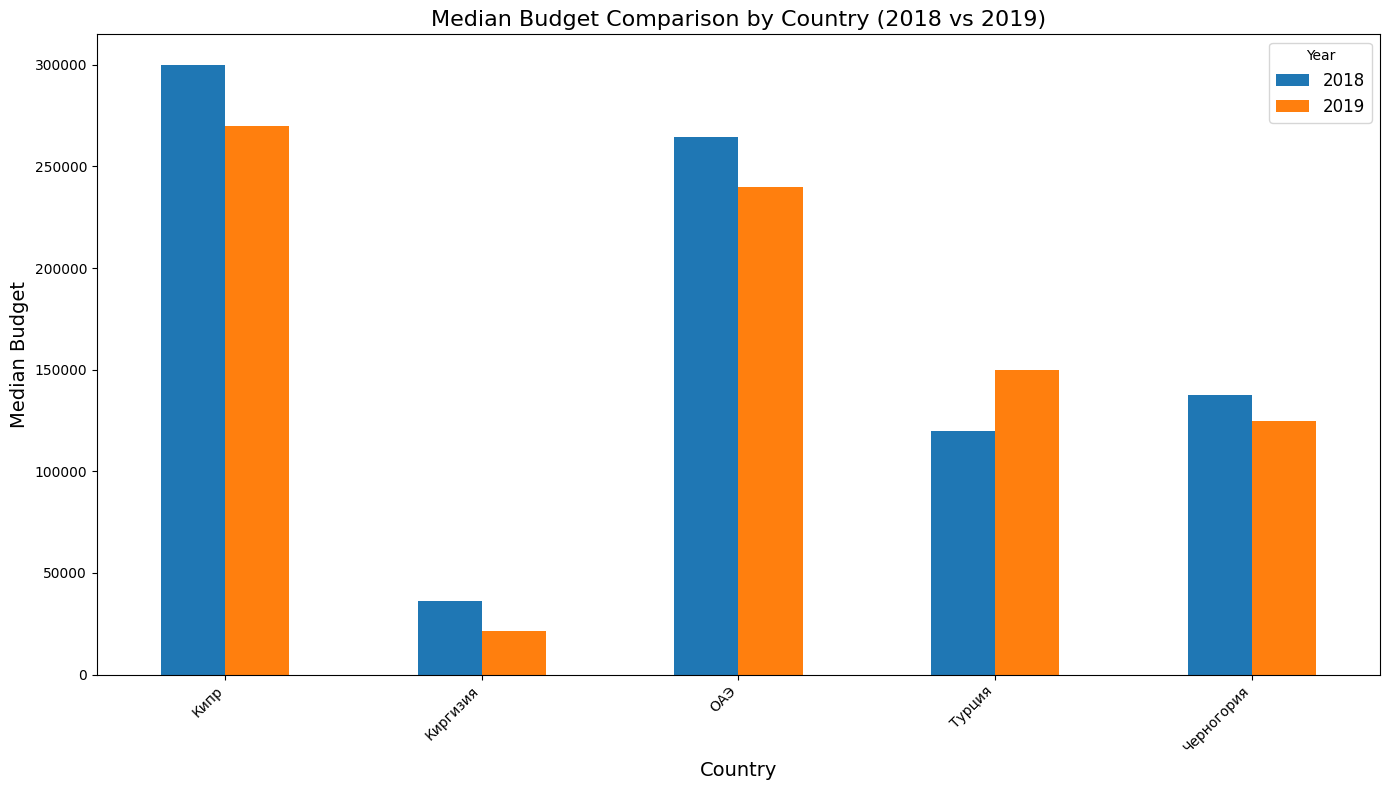

In [404]:
grouped_df = demand_budget_comparison.groupby(['Страна покупки или заявки', 'Год заявки'])['median_budget'].median().unstack()

# Строю график сравнения
grouped_df.plot(kind='bar', figsize=(14, 8))
plt.title('Median Budget Comparison by Country (2018 vs 2019)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Median Budget', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year', fontsize=12)
plt.tight_layout()
plt.show()

Преобразовываю данные для удобного сравнения

In [405]:
comparison_pivot = demand_budget_comparison.pivot(index='Страна покупки или заявки', 
                                                  columns='Год заявки', 
                                                  values=['total_leads', 'avg_budget', 'median_budget'])


In [406]:
comparison_pivot

total_leads           avg_budget                \
Год заявки                       2018   2019          2018          2019   
Страна покупки или заявки                                                  
Кипр                             42.0   81.0  4.849256e+05  3.810740e+05   
Киргизия                          1.0    5.0  3.600000e+04  9.003800e+04   
ОАЭ                              47.0  245.0  1.061385e+06  3.487962e+05   
Турция                          134.0  134.0  3.454799e+05  1.039174e+06   
Черногория                       36.0   26.0  2.915690e+05  2.073783e+05   

                          median_budget            
Год заявки                         2018      2019  
Страна покупки или заявки                          
Кипр                           300000.0  270000.0  
Киргизия                        36000.0   21672.0  
ОАЭ                            264435.0  240000.0  
Турция                         120000.0  150000.0  
Черногория                     137500.0  125000.0

Выводы по изменениям спроса и медианных бюджетов:

ОАЭ показали самый значительный рост спроса (+421.3%) с увеличением заявок с 47 до 245. Однако, несмотря на увеличение спроса, медианный бюджет снизился на 9.2%. Это может свидетельствовать о привлечении большего числа заявок с более низкими бюджетами.

Киргизия также продемонстрировала существенный рост спроса (+400%), но с резким снижением медианного бюджета на 39.8%. Это может быть связано с изменением структуры спроса или ориентацией на менее платежеспособных клиентов.

Кипр показал стабильный рост спроса (+92.9%), увеличив количество заявок с 42 до 81, при этом медианный бюджет снизился на 10%. Это указывает на увеличение интереса, но с некоторым снижением среднего уровня платежеспособности клиентов.

Турция продемонстрировала стабильность в спросе (0% изменений), сохраняя количество заявок на уровне 134. Однако медианный бюджет вырос на 25%, что говорит об увеличении платежеспособности клиентов, несмотря на отсутствие роста количества заявок.

Черногория отметилась снижением спроса (-27.8%) и медианного бюджета (-9.1%). Это может быть признаком снижения интереса к данному направлению или уменьшения активности более крупных заказчиков.

Общие наблюдения:
Наиболее привлекательным направлением с точки зрения роста спроса стали ОАЭ, несмотря на снижение медианного бюджета.
Киргизия и Кипр показывают рост интереса, но сопровождающийся снижением медианного бюджета.
Турция демонстрирует повышение уровня платежеспособности без изменения спроса, что выделяет её среди других стран.
Черногория находится в зоне снижения как спроса, так и бюджетов, что может потребовать дополнительных исследований и мер для восстановления интереса.

Средние данные по бюджетам сравнивать оказалось нецелесообразно, так как присутвуют сильные выбросы, искажающие на общую картину. Более правильно в данной ситуации будет обратиться к сранению медианных бюджетов, поскольку медиана менее подвержена влиянию аномальных значений или выбросов.


## Задание 3.1

В файле frankfurt_transactions.txt приведены данные об объемах
транзакций инвестирования в офисную недвижимость Франкфурта с I кв. 2016
по II кв. 2019 (в текущих ценах на конец соответствующего квартала). Дайте
прогноз об объемах транзакций на III и IV кв. 2019 в предположении, что на
рынке не произойдет резких изменений.

Считываю файл, сохраненный в моей локальной директории

In [407]:
file_path = r'C:\Users\Julia\Desktop\frankfurt_transactions.txt'
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')

In [408]:
df

,Год,Квартал,"Объём транзакций, млн евро"
0,2016,I,"1302,22"
1,2016,II,"1376,47"
2,2016,III,"1260,3"
3,2016,IV,"1407,78"
4,2017,I,"1444,16"
5,2017,II,"1292,52"
6,2017,III,"1387,19"
7,2017,IV,"1609,2"
8,2018,I,"1381,32"
9,2018,II,"1882,73"


Предобрабатываю данные

In [409]:
# заменяю ',' на '.', преобразую строковых значений в числовые
df['Объём транзакций, млн евро'] = df['Объём транзакций, млн евро'].str.replace(',', '.').astype(float)
# сопоставляю кварталы с месяцами
quarter_mapping = {'I': '01', 'II': '04', 'III': '07', 'IV': '10'}
df['Месяц'] = df['Квартал'].map(quarter_mapping)
# создаю столбец с датой
df['Дата'] = pd.to_datetime(df['Год'].astype(str) + '-' + df['Месяц'] + '-01')
# сортирую и осталяю данные для работы
df = df[['Дата', 'Объём транзакций, млн евро']].sort_values('Дата')

Строю график исторических данных

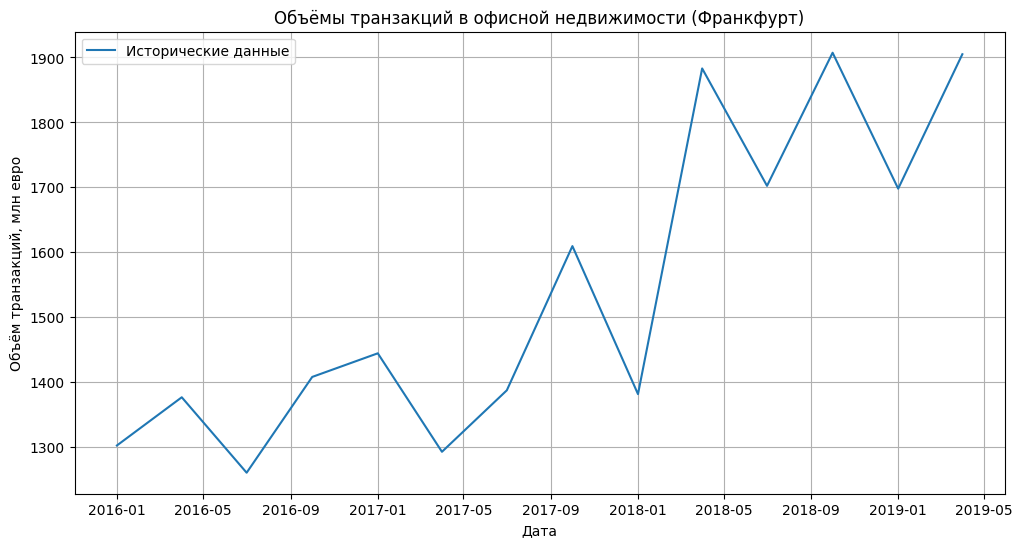

In [410]:
plt.figure(figsize=(12, 6))
plt.plot(df['Дата'], df['Объём транзакций, млн евро'], label='Исторические данные')
plt.title('Объёмы транзакций в офисной недвижимости (Франкфурт)')
plt.xlabel('Дата')
plt.ylabel('Объём транзакций, млн евро')
plt.legend()
plt.grid()
plt.show()

Делаю прогнозирование с использованием модели Хольта-Винтерса. Я выбрала этот метод, потому что в наших данных есть сезонность.

In [ ]:
model = ExponentialSmoothing(  #задаю нужные парметры для модели
    df['Объём транзакций, млн евро'],
    trend='add',
    seasonal='add',
    seasonal_periods=4
).fit()

Прогноз на 2 квартала

In [ ]:
# указываю нужно количество периодов (2 квартала) и и получаю последние данные, чтобы модель занала от какой точки нужно делать прогноз
forecast_periods = 2
last_date = df['Дата'].iloc[-1]

# Создаю даты для прогнозируемых кварталов
forecast_dates = pd.date_range(
    start=last_date + pd.offsets.QuarterEnd(1),  # Сдвиг к следующему концу квартала
    periods=forecast_periods,
    freq='QE' 
)

# Прогнозирую
forecast = model.forecast(steps=forecast_periods)

Формирование результатов прогноза

In [419]:
forecast_results = pd.DataFrame({ 
    'Дата': forecast_dates,
    'Прогнозируемый объём, млн евро': forecast
})

In [420]:
forecast_results

,Дата,"Прогнозируемый объём, млн евро"
14,2019-06-30,1822.929781
15,2019-09-30,2013.885095


График прогноза

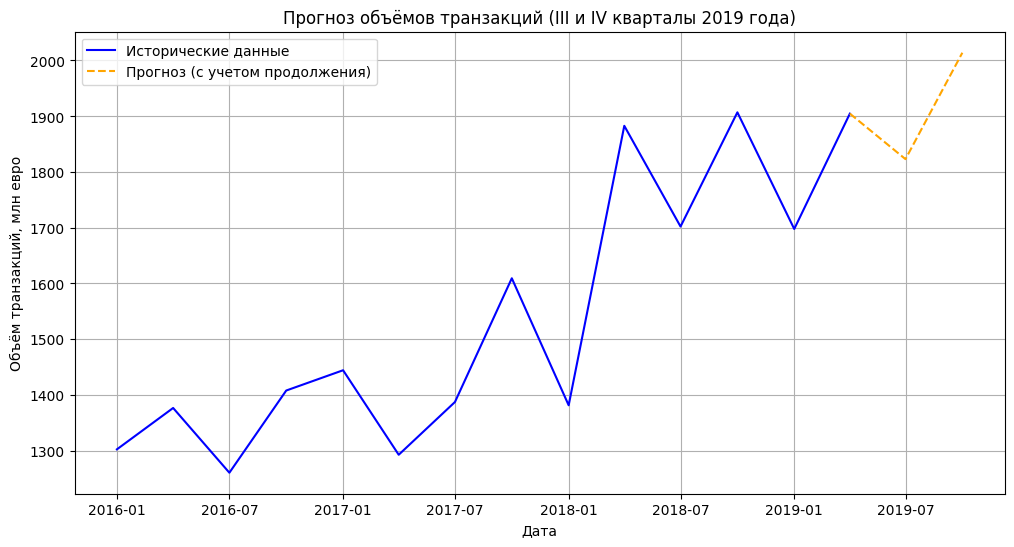

In [415]:
plt.figure(figsize=(12, 6))
plt.plot(df['Дата'], df['Объём транзакций, млн евро'], label='Исторические данные', color='blue')
plt.plot(
    [df['Дата'].iloc[-1]] + list(forecast_dates),
    [df['Объём транзакций, млн евро'].iloc[-1]] + list(forecast),
    label='Прогноз (с учетом продолжения)', linestyle='--', color='orange'
)
plt.title('Прогноз объёмов транзакций (III и IV кварталы 2019 года)')
plt.xlabel('Дата')
plt.ylabel('Объём транзакций, млн евро')
plt.legend()
plt.grid()
plt.show()
